## ATAC + MULTIOME gonadal somatic cells (july 2021)

### Convert to Seurat objects for CICERO

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.21.2
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_july2021/"
experiment_prefix = 'supporting_'

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [9]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 74592 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8', 'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb', 'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa', 'max', 'leiden_R', 'leiden_2', 'leiden_3', 'stage_numeric', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'colors_somatic', '

In [10]:
ATAC_scanpy = ATAC_scanpy[[i in ['female'] for i in ATAC_scanpy.obs['sex']]]
ATAC_scanpy.shape

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(43643, 159132)

In [11]:
ATAC_scanpy = ATAC_scanpy[[i in ['CoelEpi_LHX9',  'early_supporting', 'sPAX8', 'preGC_I',
                                 'OSE', 'preGC_IIa', 'preGC_IIb','granulosa'] for i in ATAC_scanpy.obs['cell_type']]]


In [12]:
ATAC_scanpy.obs['cell_type'].value_counts(dropna = False)

preGC_IIa           8369
preGC_I             6567
early_supporting    5787
preGC_IIb           5721
OSE                 4728
sPAX8               1445
granulosa           1177
CoelEpi_LHX9         908
Name: cell_type, dtype: int64

In [13]:
ATAC_scanpy.X

<34702x159132 sparse matrix of type '<class 'numpy.float32'>'
	with 126687922 stored elements in Compressed Sparse Row format>

In [71]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<34702x159132 sparse matrix of type '<class 'numpy.float32'>'
	with 126687922 stored elements in Compressed Sparse Row format>

In [72]:
binary_raw.shape

(34702, 159132)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [73]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [74]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7f55f064e4c0> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [75]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 159132  34702


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [76]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_45']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [77]:
del ATAC_scanpy.obs['cellatac_clusters']

In [78]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [79]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:816748-817444" "chr1:825667-826059" "chr1:826598-827811"
[4] "chr1:868830-869161" "chr1:869380-870259" "chr1:875055-875919"
[1] "01-AAACCGGCAACCCTCC-1" "01-AAACCGGCAAGTAAGC-1" "01-AAACGGATCCGCCAAA-1"
[4] "01-AAACGTACAGGTTATT-1" "01-AAAGCCGCAAGCCACT-1" "01-AAAGCTTGTAGCTAAT-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [80]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 159132 features for 34702 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [81]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
159132 features across 34702 samples within 1 assay 
Active assay: peaks (159132 features, 0 variable features)


In [82]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$cell_type))


  F81 Hrv11 Hrv12 Hrv13 Hrv39 Hrv49 Hrv50 Hrv58 Hrv59 Hrv65 Hrv91 Hrv92 
 6445   223  1000  2422   510  3587  5570  2493  1017  2226  2142  7067 

    CoelEpi_LHX9 early_supporting            sPAX8          preGC_I 
             908             5787             1445             6567 
             OSE        preGC_IIa        preGC_IIb        granulosa 
            4728             8369             5721             1177 


Step 5: Add dimensionality reductions to Seurat object 

In [83]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [84]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [85]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [86]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
159132 features across 34702 samples within 1 assay 
Active assay: peaks (159132 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


### Save RDS object of females 

In [87]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_for_Luz.rds"))

In [88]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat <- readRDS(file = paste0(outdir, experiment_prefix, "_for_Luz.rds"))

## TF motifs with ChromVar

#### Add motifs

In [89]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)
print(names(pfm))

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}
#print(names(tf_motif_SwissRegulon))

# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
# print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
#print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

  [1] "MA0025.1" "MA0030.1" "MA0031.1" "MA0051.1" "MA0056.1" "MA0057.1"
  [7] "MA0059.1" "MA0066.1" "MA0069.1" "MA0070.1" "MA0071.1" "MA0072.1"
 [13] "MA0073.1" "MA0074.1" "MA0077.1" "MA0081.1" "MA0084.1" "MA0091.1"
 [19] "MA0101.1" "MA0107.1" "MA0115.1" "MA0119.1" "MA0130.1" "MA0139.1"
 [25] "MA0149.1" "MA0138.2" "MA0152.1" "MA0155.1" "MA0158.1" "MA0159.1"
 [31] "MA0160.1" "MA0163.1" "MA0259.1" "MA0462.1" "MA0465.1" "MA0468.1"
 [37] "MA0470.1" "MA0471.1" "MA0476.1" "MA0477.1" "MA0478.1" "MA0479.1"
 [43] "MA0484.1" "MA0488.1" "MA0489.1" "MA0490.1" "MA0491.1" "MA0492.1"
 [49] "MA0497.1" "MA0501.1" "MA0502.1" "MA0504.1" "MA0506.1" "MA0507.1"
 [55] "MA0513.1" "MA0516.1" "MA0517.1" "MA0523.1" "MA0527.1" "MA0528.1"
 [61] "MA0102.3" "MA0076.2" "MA0258.2" "MA0148.3" "MA0050.2" "MA0079.3"
 [67] "MA0137.3" "MA0144.2" "MA0140.2" "MA0093.2" "MA0095.2" "MA0593.1"
 [73] "MA0595.1" "MA0596.1" "MA0597.1" "MA0599.1" "MA0610.1" "MA0612.1"
 [79] "MA0613.1" "MA0618.1" "MA0625.1" "MA0628.1" "MA0630.1" "MA

#### Add motifs

In [90]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
159132 features across 34702 samples within 1 assay 
Active assay: peaks (159132 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute per-cell motif activity scores with chromVar

In [91]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
161052 features across 34702 samples within 2 assays 
Active assay: peaks (159132 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [92]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary_supportingOvary_with_earlyPAX8.rds"))

In [93]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [94]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [14]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary_supportingOvary_with_earlyPAX8.rds"))
ATAC_Seurat_withChromVar

An object of class Seurat 
161052 features across 34702 samples within 2 assays 
Active assay: peaks (159132 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [15]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$cell_type
print(table(Idents(ATAC_Seurat_withChromVar)))


    CoelEpi_LHX9 early_supporting            sPAX8          preGC_I 
             908             5787             1445             6567 
             OSE        preGC_IIa        preGC_IIb        granulosa 
            4728             8369             5721             1177 


In [16]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [17]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR_supportingOvary_with_earlyPAX8.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~18m 56s       |++                                                | 2 % ~18m 46s       |++                                                | 3 % ~17m 22s       |+++                                               | 4 % ~16m 21s       |+++                                               | 5 % ~15m 32s       |++++                                              | 6 % ~14m 29s       |++++                                              | 7 % ~13m 35s       |+++++                                             | 8 % ~13m 23s       |+++++                                             | 9 % ~12m 60s       |++++++                                            | 10% ~12m 59s       |++++++                                            | 11% ~12m 37s       |+++++++                                           | 12% ~12m 25s       |+++++++                                           | 14% ~12m 

#### z-scores per cell type annotation

In [18]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary_supportingOvary_with_earlyPAX8.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
ATAC_Seurat_withChromVar

An object of class Seurat 
161052 features across 34702 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [19]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [20]:
chromvar_assay.shape

(34702, 1920)

In [21]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'cell_type']]
cells_celltypes.head()

Trying to set attribute `.obs` of view, copying.


,barcode,cell_type
01-AAACCGGCAACCCTCC-1,01-AAACCGGCAACCCTCC-1,early_supporting
01-AAACCGGCAAGTAAGC-1,01-AAACCGGCAAGTAAGC-1,early_supporting
01-AAACGGATCCGCCAAA-1,01-AAACGGATCCGCCAAA-1,OSE
01-AAACGTACAGGTTATT-1,01-AAACGTACAGGTTATT-1,early_supporting
01-AAAGCCGCAAGCCACT-1,01-AAAGCCGCAAGCCACT-1,preGC_IIb


In [22]:
cells_mapping_clusters = cells_celltypes.groupby('cell_type').groups

In [23]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

CoelEpi_LHX9
early_supporting
sPAX8
preGC_I
OSE
preGC_IIa
preGC_IIb
granulosa


In [24]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['CoelEpi_LHX9', 'OSE', 'early_supporting', 'granulosa', 'preGC_I', 'preGC_IIa', 'preGC_IIb', 'sPAX8']


In [25]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [26]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore_supportingOvary_with_earlyPAX8.csv")

In [28]:
experiment_prefix

'supporting_'

In [46]:
chromvar_assay_zscore = chromvar_assay_zscore.reindex(['CoelEpi_GATA2', 'CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I',
    'OSE', 'preGC_IIa', 'preGC_IIb', 'granulosa',
     'Oi', 'Ti', 'Gi', 'Sertoli', 'FetalLeydig'
                                          ])


In [47]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, s = 100, l = 40,n=10, as_cmap=True)


In [48]:
chromvar_assay_zscore.shape

(14, 1920)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


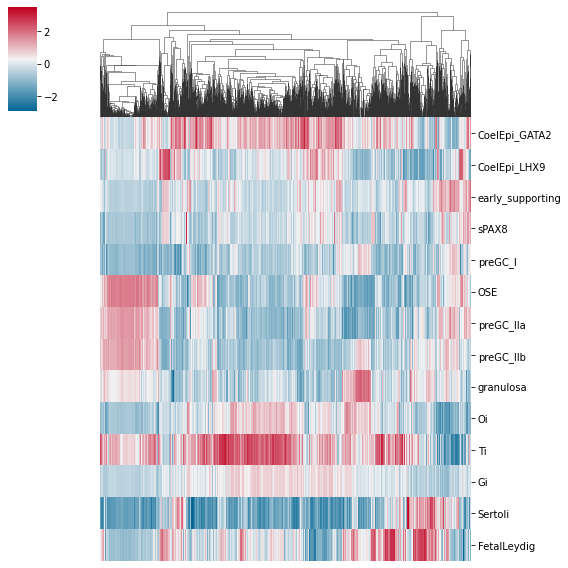

In [49]:
heatmap_TFs = sns.clustermap(chromvar_assay_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_somatic/heatmap_supporting_TFs.pdf")


### Select top 3 TFs per cell type 

In [56]:
top_tfs = []
for c in chromvar_assay_zscore.index:
    df_c = chromvar_assay_zscore.loc[c]
    df_c = df_c.sort_values(axis = 0, ascending = False)
    top_4 = df_c[0:5].index
    top_tfs.extend(top_4)

In [57]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore[top_tfs]

In [58]:
chromvar_assay_zscore_top4.columns

Index(['NFYA.MA0060.3', 'DMRT6.HOMER', 'NFYB.MA0502.1', 'CEBPZ.SwissRegulon',
       'TFAP2D.SwissRegulon', 'EGR2.SwissRegulon', 'PROX1-HUMAN.H10MO.D',
       'TEAD4-HUMAN.H10MO.A', 'HLF-HUMAN.H10MO.C', 'HLF.SwissRegulon',
       'EGR1.SwissRegulon', 'EGR2.MA0472.2', 'PAX1.MA0779.1', 'PAX9.MA0781.1',
       'EGR1-HUMAN.H10MO.S', 'ID4-HUMAN.H10MO.D', 'SMAD4-HUMAN.H10MO.C',
       'MESP1.SwissRegulon', 'SMAD2-HUMAN.H10MO.C', 'TCF3.MA0522.2',
       'MNX1.MA0707.1', 'VSX1.MA0725.1', 'VSX2.MA0726.1', 'MEOX2.MA0706.1',
       'GSX2.MA0893.1', 'SF1.HOMER', 'ESRRB.MA0141.3', 'HXD3-HUMAN.H10MO.D',
       'ERR2-HUMAN.H10MO.A', 'PPARA.SwissRegulon', 'NR4A2::RXRA.MA1147.1',
       'NR1A4::RXRA.MA1146.1', 'FOXF2.MA0030.1', 'FOXG1.MA0613.1',
       'FOXB1.SwissRegulon', 'MSC.MA0665.1', 'TFAP4.MA0691.1',
       'MSC.SwissRegulon', 'TFAP4-HUMAN.H10MO.C', 'NHLH1.MA0048.2',
       'ARNT::HIF1A.MA0259.1', 'OLIG1.SwissRegulon', 'HIF1A.MA1106.1',
       'NR3C2.SwissRegulon', 'BHLHE22.SwissRegulon', 'HOXC1

In [59]:
to_plot = ['DMRT6.HOMER', 'EGR2.SwissRegulon', 'PAX1.MA0779.1', 'FOXF2.MA0030.1','MNX1.MA0707.1', 
            'MESP1.SwissRegulon',  'TCF3.MA0522.2',  'MSC.SwissRegulon','OLIG1.SwissRegulon','HOXC13.MA0907.1',
             'HSF2.MA0770.1', 'TWIST1.MA1123.1','EBF3.SwissRegulon',
           'HNF1B.MA0153.2', 'FLI1.SwissRegulon', 'SPI1.MA0080.4', 'RFX3.SwissRegulon',
           ]
len(to_plot)

17

In [60]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore_top4[to_plot]
chromvar_assay_zscore_top4.columns

Index(['DMRT6.HOMER', 'EGR2.SwissRegulon', 'PAX1.MA0779.1', 'FOXF2.MA0030.1',
       'MNX1.MA0707.1', 'MESP1.SwissRegulon', 'TCF3.MA0522.2',
       'MSC.SwissRegulon', 'OLIG1.SwissRegulon', 'HOXC13.MA0907.1',
       'HSF2.MA0770.1', 'TWIST1.MA1123.1', 'EBF3.SwissRegulon',
       'HNF1B.MA0153.2', 'FLI1.SwissRegulon', 'SPI1.MA0080.4',
       'RFX3.SwissRegulon'],
      dtype='object')

In [61]:
chromvar_assay_zscore_top4.columns = [col.split(".")[0] for col in chromvar_assay_zscore_top4.columns]

In [91]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


<ipython-input-91-63a9665b3b7d>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


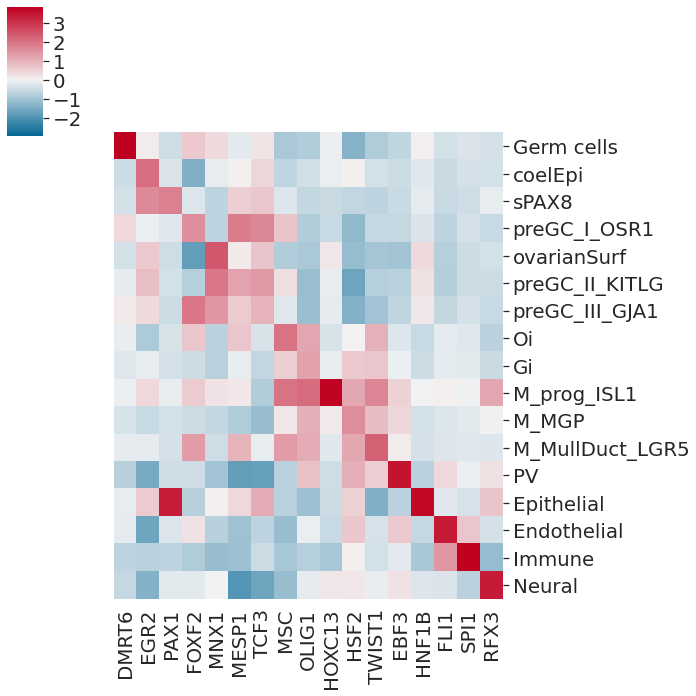

In [63]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_top4, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(10, 10),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_females/heatmap_females_TFs_top1_curated.pdf")


### Plot TFs associated with DSD

In [59]:
dsd_tfs = ['ARX', 'ATRX', 'BMP15', 'CBX2', 'DAX1', 'DHH', 'DHX37', 'DMRT1', 'EMX2', 'ESR2', 'FGF9', 'FGFR2', 'FOXL2',
          'GATA4', 'HHAT', 'MAP3K1', 'NR2F2', 'NR5A1', 'NUP107', 'RSPO1', 'SOX3', 'SOX8', 'SOX9', 'SOX10', 'SRY', 
          'STARD8', 'TSPYL1', 'WNT4', 'WT1', 'WWOX', 'ZFPM2', 'ZNRF3']

In [83]:
df = pd.DataFrame(chromvar_assay_zscore.columns)

In [85]:
df[0][df[0].str.contains('|'.join(dsd_tfs))]


14            SOX9.MA0077.1
16             SRY.MA0084.1
62            ESR2.MA0258.2
338           SOX8.MA0868.1
343          BARX1.MA0875.1
348           EMX2.MA0886.1
393          NR2F2.MA1111.1
404          SOX10.MA0442.2
467       ARX-HUMAN.H10MO.D
478     BARX1-HUMAN.H10MO.D
479     BARX2-HUMAN.H10MO.D
561      EMX2-HUMAN.H10MO.D
571      ESR2-HUMAN.H10MO.A
572      ESR2-HUMAN.H10MO.S
627     GATA4-HUMAN.H10MO.B
958     SOX10-HUMAN.H10MO.D
967      SOX3-HUMAN.H10MO.D
971      SOX8-HUMAN.H10MO.D
972      SOX9-HUMAN.H10MO.B
986       SRY-HUMAN.H10MO.B
1049      WT1-HUMAN.H10MO.D
1102       ARX.SwissRegulon
1116     BARX1.SwissRegulon
1117     BARX2.SwissRegulon
1199      EMX2.SwissRegulon
1208      ESR2.SwissRegulon
1265     GATA4.SwissRegulon
1502     NR2F2.SwissRegulon
1624     SOX10.SwissRegulon
1635     SOX30.SwissRegulon
1636      SOX3.SwissRegulon
1641      SOX8.SwissRegulon
1642      SOX9.SwissRegulon
1656       SRY.SwissRegulon
1724       WT1.SwissRegulon
1791            DMRT

In [96]:
dsd_tfs_present = ['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon', 'ESR2.SwissRegulon',
                  'GATA4.SwissRegulon', 'FOXL2.HOMER',
                  'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 
                   'SOX8-HUMAN.H10MO.D', 'SOX9.SwissRegulon', 
                  'SOX10.SwissRegulon', 'SRY.SwissRegulon', 
                  'WT1-HUMAN.H10MO.D']


In [97]:
chromvar_assay_zscore_DSD = chromvar_assay_zscore[dsd_tfs_present]
chromvar_assay_zscore_DSD.columns

Index(['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon',
       'ESR2.SwissRegulon', 'GATA4.SwissRegulon', 'FOXL2.HOMER',
       'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 'SOX8-HUMAN.H10MO.D',
       'SOX9.SwissRegulon', 'SOX10.SwissRegulon', 'SRY.SwissRegulon',
       'WT1-HUMAN.H10MO.D'],
      dtype='object')

In [98]:
chromvar_assay_zscore_DSD.columns = [col.split(".")[0] for col in chromvar_assay_zscore_DSD.columns]
chromvar_assay_zscore_DSD.columns = [col.split("-")[0] for col in chromvar_assay_zscore_DSD.columns]


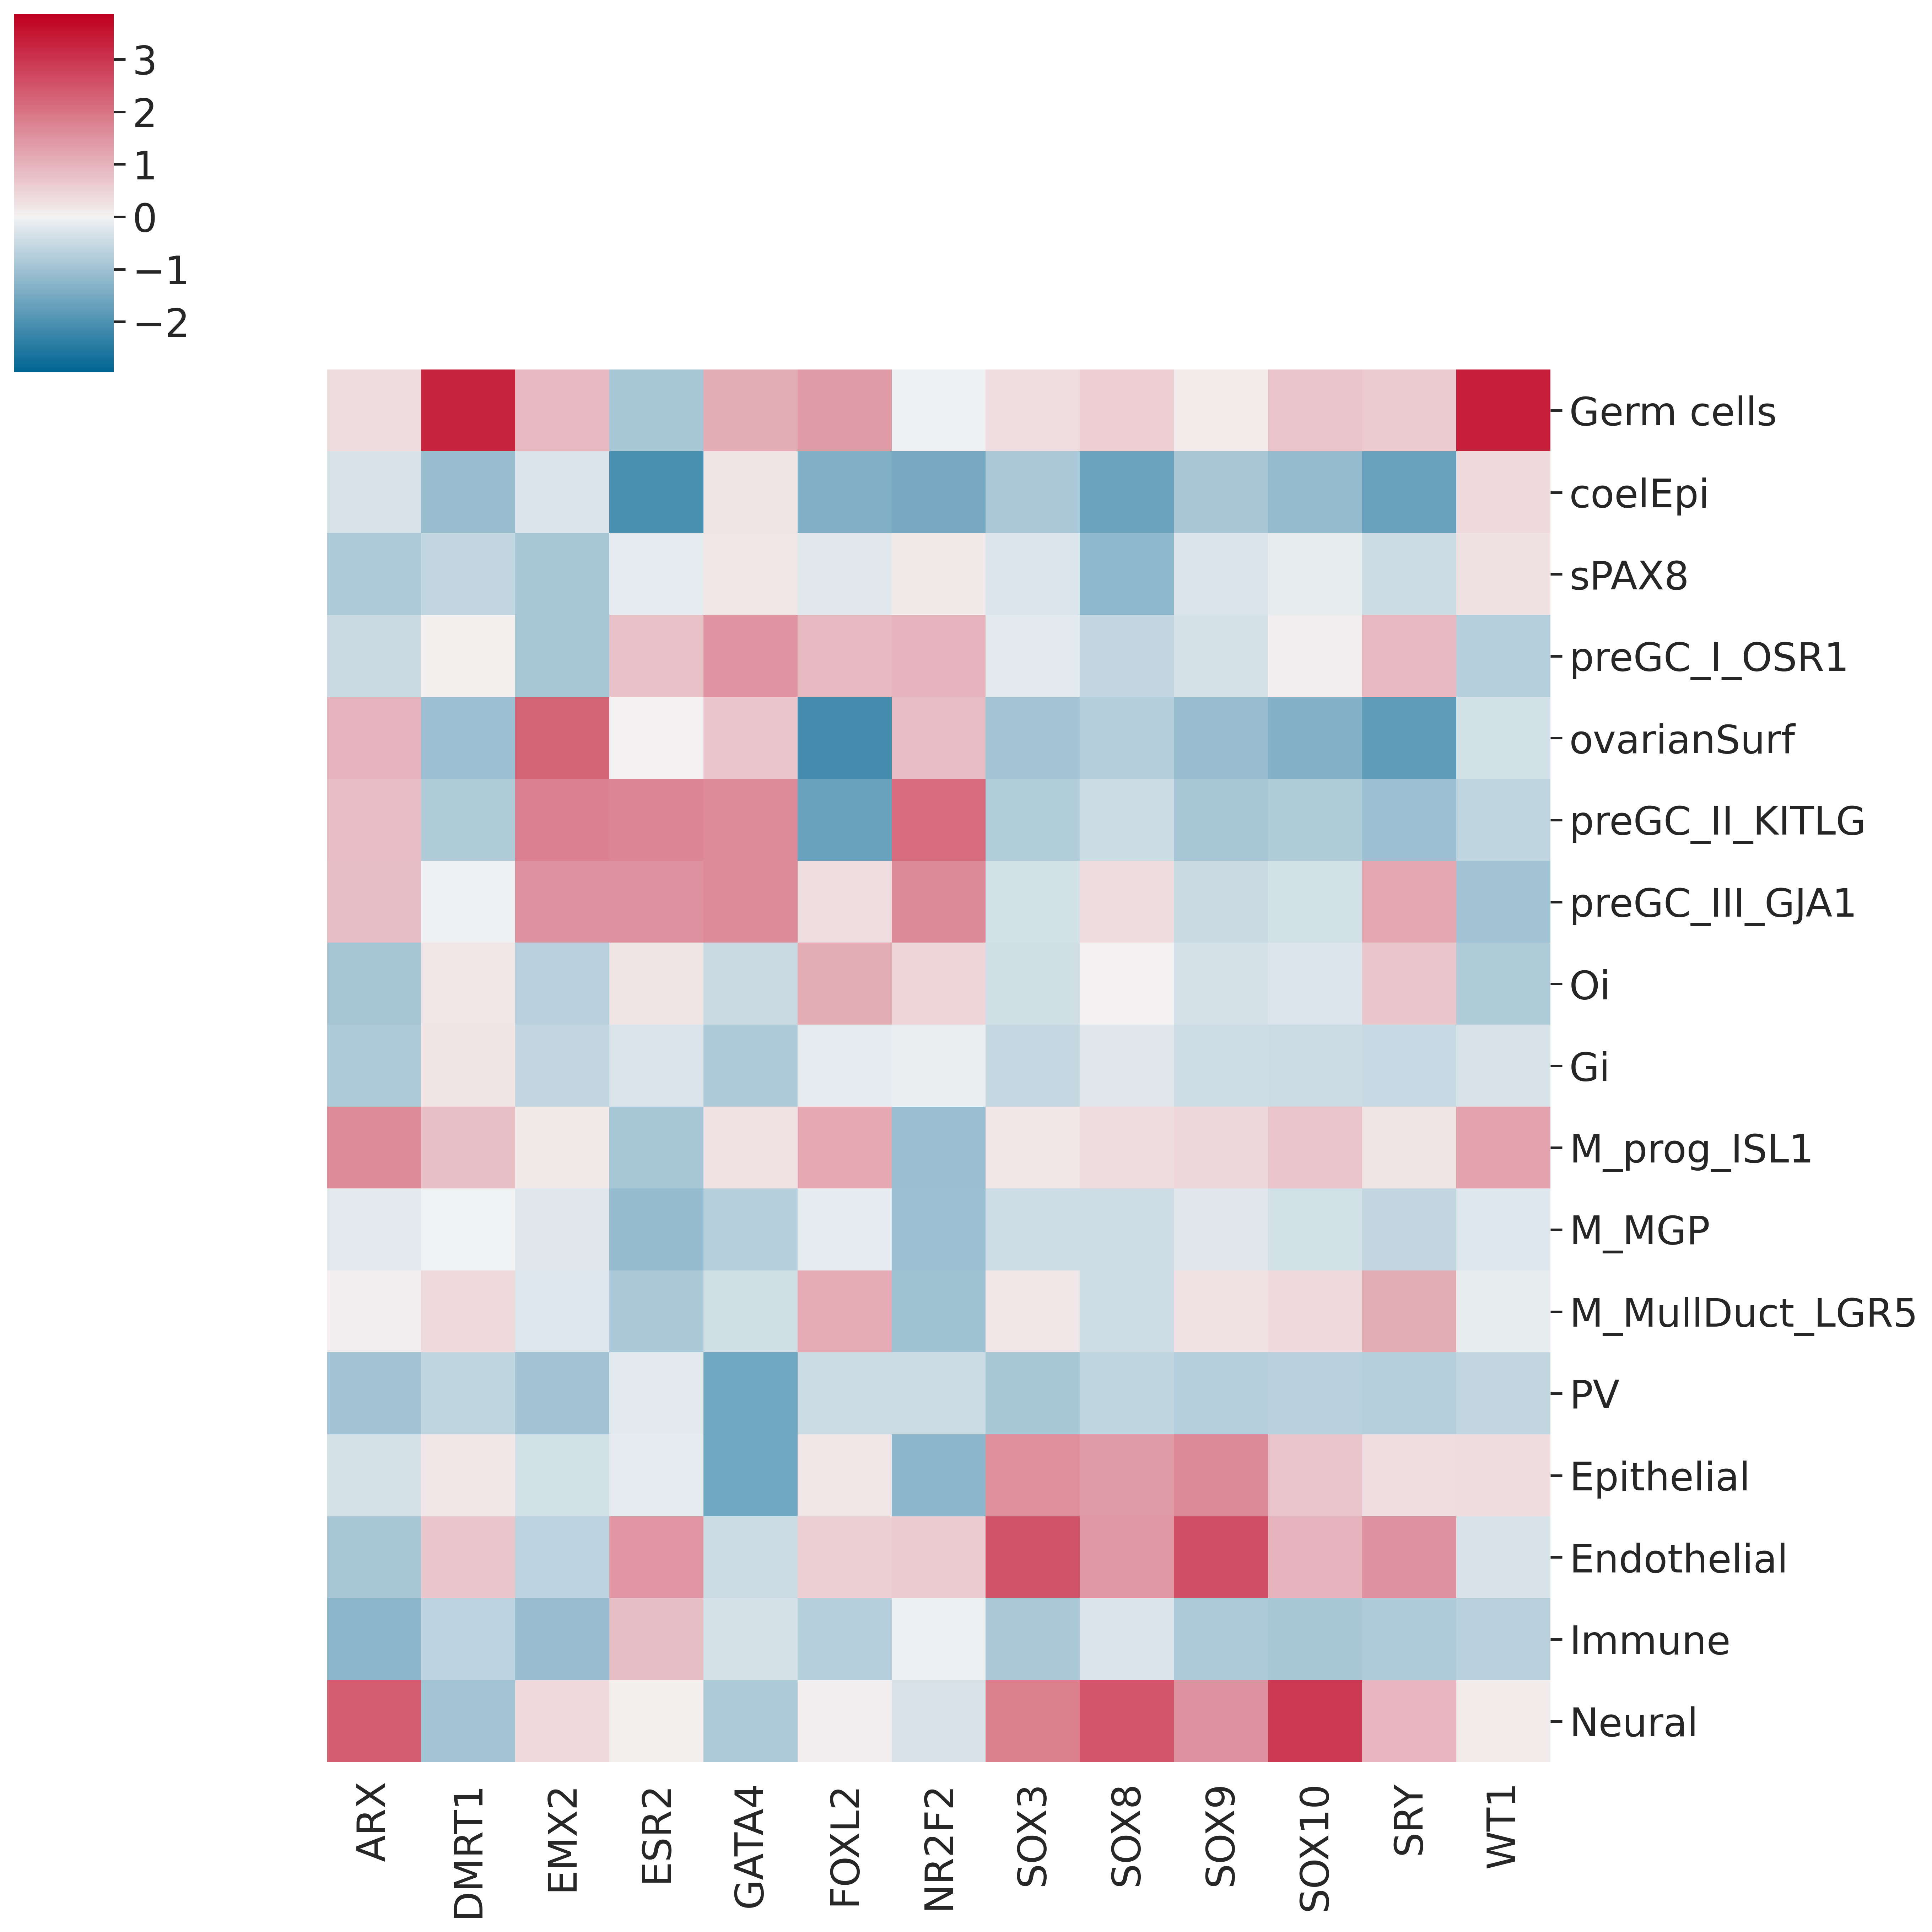

In [99]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_DSD, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(14, 14),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_females/DSD_TFs_heatmap.pdf")


#### End of notebook